## Prerequisite

In [640]:
!uv pip install seaborn numpy matplotlib scikit-learn
!uv pip install jax flax optax
!uv pip install jax-metal
!uv pip install tqdm

/Users/chenwuhao/.pyenv/versions/3.11.8/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
/Users/chenwuhao/.pyenv/versions/3.11.8/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
24396.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Audited 4 packages in 14ms


24401.40s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Audited 3 packages in 12ms


24406.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Audited 1 package in 5ms


24411.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Resolved 1 package in 224ms                                                  
Downloaded 1 package in 39ms                                                     
Installed 1 package in 10ms                                         
 + tqdm==4.66.4


In [645]:
from sklearn.datasets import make_swiss_roll
from typing import Sequence
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

import jax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax


## Loading Toy Dataset

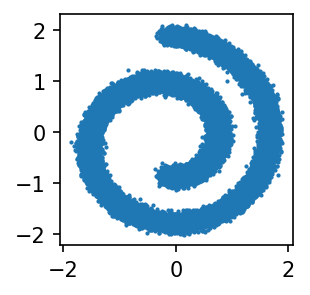

In [170]:
x, _ = make_swiss_roll(n_samples=100000, noise=0.5)
x = x[:, [0, 2]]

x = (x - x.mean()) / x.std()

plt.figure(figsize=(2, 2), dpi=150)
plt.scatter(x[:, 0], x[:, 1], s=1)

### MLP

In [735]:
class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.tanh(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    x = jnp.square(x)
    return x

### Fitting the Energy Function on this toy distribution

In [773]:
@jax.jit
def energy(state, params, x):
    return state.apply_fn({'params': params}, x).squeeze()

@jax.jit
def grad_energy_wrt_x(state, params, x):
    return jax.vmap(jax.grad(energy, argnums=2), in_axes=(None, None, 0))(state, params, x)

@jax.jit
def sample_langevin_dynamics(key, state, params, x, num_steps=3, step_size=0.01):
    def step(i, x):
        noise = jax.random.normal(jax.random.fold_in(key, i), shape=x.shape)
        grad = grad_energy_wrt_x(state, params, x)
        x = x - (step_size / 2.) * grad + jnp.sqrt(step_size) * noise
        return x
    
    return jax.lax.fori_loop(0, num_steps, step, x)

### Train the model using Langevin MCMC and Contrastive Divergence

In [774]:
@jax.jit
def train_mcmc_with_langevin(state, batch, key):
    key, subkey = jax.random.split(key)
    # prior = jax.random.normal(subkey, (256, 2))
    model_samples = sample_langevin_dynamics(subkey, state, state.params, batch)
    model_samples = jax.lax.stop_gradient(model_samples)

    def loss_fn(params):
        concat_samples = jnp.concatenate([batch, model_samples], axis=0)
        energies = energy(state, params, concat_samples)
        data_energy, model_energy = jnp.split(energies, 2)

        regularisation = 0.1 * (data_energy ** 2 + model_energy ** 2).mean()

        return data_energy.mean() - model_energy.mean() + regularisation

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

In [775]:
x = make_swiss_roll(n_samples=100000, noise=0.5)[0]
x = x[:, [0, 2]]

x = (x - x.mean()) / x.std()

In [776]:
model = MLP(features=[2, 128, 128, 1])
variables = model.init(jax.random.PRNGKey(0), x[0])

tx = optax.chain(
    optax.clip_by_global_norm(2.0),
    optax.adamw(learning_rate=1e-3)
)
key = jax.random.PRNGKey(0)
state = train_state.TrainState.create(apply_fn=model.apply, params=variables["params"], tx=tx)

In [785]:
# Training loop
num_epochs = 500
batch_size = 128

for epoch in range(num_epochs):
    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, x.shape[0])
    permed_x = x[perm]
    
    for i in range(0, x.shape[0], batch_size):
        batch = jnp.array(permed_x[i:i + batch_size])
        key, subkey = jax.random.split(key)
        state, loss = train_mcmc_with_langevin(state, batch, subkey)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss}")

print("Training complete.")

Epoch 5, Loss: -0.2336171269416809
Epoch 10, Loss: -0.33612269163131714


KeyboardInterrupt: 

In [755]:
x.mean(), x.std()

(np.float64(-7.73070496506989e-17), np.float64(0.9999999999999998))

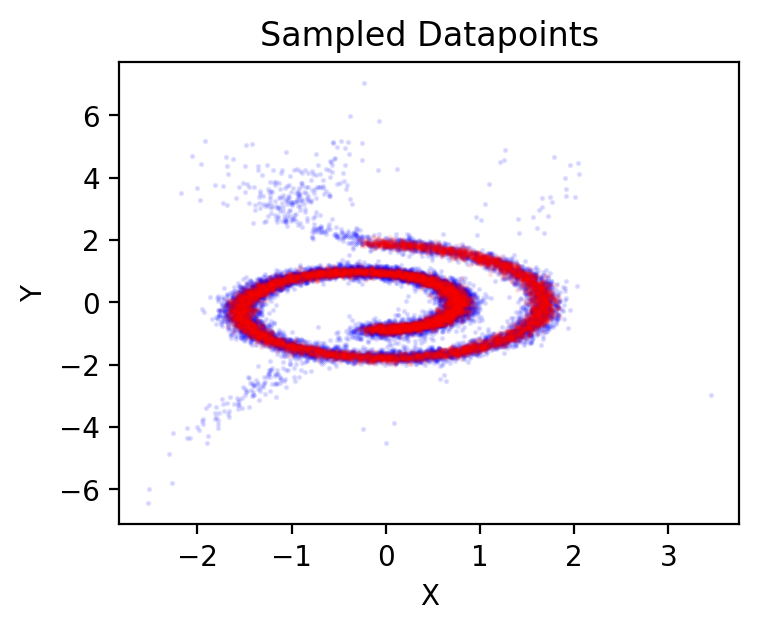

In [786]:
prior = jax.random.normal(key, (10000, 2))
model_samples = sample_langevin_dynamics(key, state, state.params, prior, num_steps=200, step_size=0.01)

plt.figure(figsize=(4, 3), dpi=200)
plt.scatter(model_samples[:, 0], model_samples[:, 1], s=1, color='blue', alpha=0.1)
plt.scatter(x[:10000, 0], x[:10000, 1], s=1, color='red', alpha=0.08)
plt.title('Sampled Datapoints')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

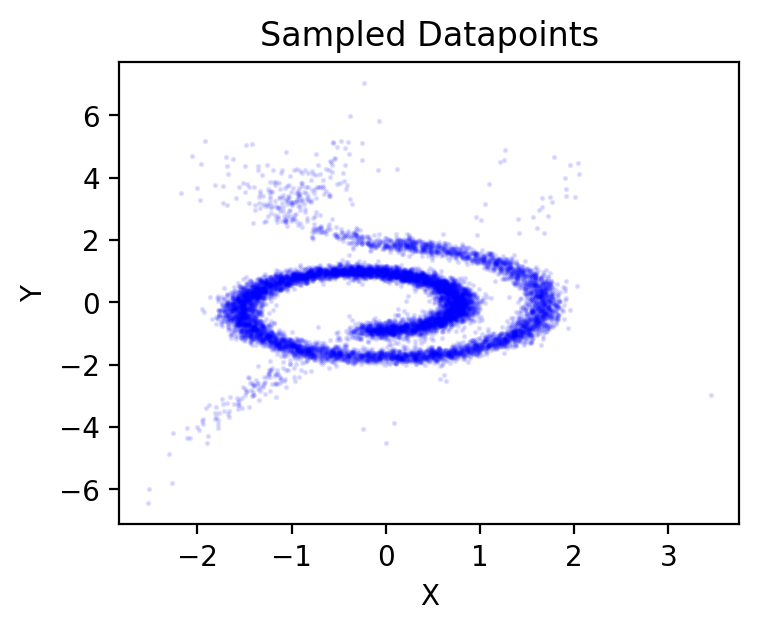

In [787]:
plt.figure(figsize=(4, 3), dpi=200)
plt.scatter(model_samples[:, 0], model_samples[:, 1], s=1, color='blue', alpha=0.1)
# plt.scatter(x[:10000, 0], x[:10000, 1], s=1, color='red', alpha=0.08)
plt.title('Sampled Datapoints')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()